# Prediction and Data Post-processing

This notebook combines the subimages into image of original size. It uses X_train data to do the experiment and visualize some of the image to make sure the function works properly.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 

import numpy as np
import cv2
import glob
from math import ceil

from keras.models import Model
from keras.layers import Input,merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D,Dropout,Conv2DTranspose
from keras.layers.normalization import BatchNormalization as bn
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers 
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


Using TensorFlow backend.


In [16]:
def load_test():
    """This function takes in test.npy file which is generated in preprocessing.py by Raun
    The size of original np array is (221,100,image_size_x,image_size_y)
    It flatten the array into size (22100,image_size_x,image_size_y)"""
    file_num = len(glob.glob("../X_test_*.npy"))
    train_set = []
    for num in range(file_num):
        x_file_name = "../X_test_" + str(num) + ".npy"
        x = np.load(x_file_name)
        index = [0],#10]#,20,30,40,50,60,70,80,90]
        #for i in index:
        array = x[0]
        train_set.append(array)
        #for array in x:
            #train_set.append(array)
    return train_set

In [3]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# negative dice loss since we want the network to minimize it more
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [4]:
def slice_test_image(image):
    """This function takes in a image with size (image_size_x,image_size_y)
    It slices the input image into small subimages with size (128*128)
    It also records the number of slices made and if there is overlapping.
    if the image size is not divisible by 128, the last row/col of images overlap with the images from previous row/col"""
    new_images = []
    shape = image.shape
    x = ceil(shape[0]/128.)
    y = ceil(shape[1]/128.)
    x_last = shape[0] % 128
    y_last = shape[1] % 128
    for i in range(x):
        for j in range(y):
            if i == x-1:
                image_x = image[shape[0]-128:,:]
            else:
                image_x = image[(i)*128:(i+1)*128,:]
            if j == y-1:
                new_image = image_x[:,shape[1]-128:]
            else:
                new_image = image_x[:,(j)*128:(j+1)*128]
            new_images.append(new_image)
    return new_images,[x,y,x_last,y_last]

In [5]:
def preprocess(train_set):
    """This function create set of sliced images and masks"""
    subimage_set = []
    size_set = []
    size = len(train_set)
    for i in range(size):
        if i % 5000 == 0:
            print("finished slicing ", i, "images")
        image = train_set[i]
        images,image_shape = slice_test_image(image)
        for i in images:
            subimage_set.append(i)
        size_set.append(image_shape)
        
    return np.array(subimage_set),size_set

In [6]:
def combine_predictions(prediction,image_shapes):
    """This function takes in the prediction generated by unet.
        Input shape (num_of_subimage,image_size_x,image_size_y)
        Output is a set of images which are combined from subimages according to the original size """
    image_index = 0
    image_set = []
    for shape in image_shapes:        
        x,y,x_last,y_last = shape[0],shape[1],shape[2],shape[3]
        for i in range(x):
            image_x = prediction[image_index]
            for j in range(y):
                if image_index < len(prediction) and j!=0:
                    if i == x-1 and x_last != 0:
                        image_x = image_x[-x_last:,:] 
                        if j == y-1 and y_last != 0:
                            image_x = np.concatenate((image_x,prediction[image_index][-x_last:,-y_last:]),axis=1)
                        else:
                            image_x = np.concatenate((image_x,prediction[image_index][-x_last:,:]),axis=1)
                    elif j == y-1 and y_last != 0 and i!=x-1:
                        image_x = np.concatenate((image_x,prediction[image_index][:,-y_last:]),axis=1)                        
                    else:
                        image_x = np.concatenate((image_x,prediction[image_index]),axis=1)
                image_index += 1
            if i == 0:
                image = image_x
            else:
                image = np.concatenate((image,image_x),axis = 0)
        image_set.append(image)
    return np.array(image_set)

In [7]:
def select_cilia(image,threshold):
    x,y = image.shape[0],image.shape[1]
    for i in range(x):
        for j in range(y):
            if image[i,j] > threshold:
                image[i,j]=2
            else:
                image[i,j]=0
    return image

In [8]:
def get_hash():
    hash_list = []
    for i in range (0,114):
        h = glob.glob("../data/" + str(i) + "/*")
        hash_list.append(str(h)[-66:-2])
    return hash_list

In [17]:
test_set = load_test()

In [20]:
test_set[0]

array([[ 90,  90,  91, ...,  85,  85,  85],
       [ 87,  87,  89, ...,  84,  85,  85],
       [ 88,  85,  85, ...,  84,  86,  83],
       ..., 
       [120, 114, 123, ..., 115, 110, 106],
       [117, 113, 121, ..., 109, 109, 104],
       [120, 118, 121, ..., 110, 110, 107]], dtype=uint8)

In [21]:
x_test,image_shapes = preprocess(test_set)

finished slicing  0 images


In [22]:
x_test=x_test/255.0
x_test=x_test.reshape(x_test.shape+(1,))
x_test.shape

(1348, 128, 128, 1)

In [23]:
model = load_model("../model/basic_unet_dsp_p4_round2.h5", custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [24]:
import time

prediction = model.predict(x_test,batch_size=32)

In [25]:
prediction = prediction.reshape((-1,128,128))

In [26]:
count = 0
threshold_count = 0 
for i in prediction.flatten():
    count += 1
    if i > 0.01:
        threshold_count += 1
print(count,threshold_count)

22085632 324502


In [27]:
experiment_pic = np.array(prediction[1])
experiment_pic

array([[  8.70138592e-06,   4.74445699e-07,   1.93435127e-07, ...,
          1.73466901e-07,   1.69939383e-07,   2.07746780e-07],
       [  2.22654853e-06,   4.67435456e-07,   6.25294319e-07, ...,
          8.42870122e-07,   3.07729238e-07,   1.76841681e-07],
       [  9.42987128e-07,   2.46607783e-07,   1.28947318e-06, ...,
          6.55768531e-07,   2.10086412e-07,   2.03264960e-07],
       ..., 
       [  1.61615576e-09,   8.18596746e-10,   1.01764541e-09, ...,
          2.27784724e-07,   3.52883262e-07,   8.27206293e-07],
       [  1.34529443e-09,   5.12192455e-10,   3.29246241e-10, ...,
          1.47520907e-07,   1.89531008e-07,   4.03627268e-07],
       [  2.85526198e-08,   7.60520269e-09,   2.56725805e-08, ...,
          1.26768597e-07,   1.53800883e-07,   3.77604465e-06]], dtype=float32)

In [28]:
for i in range(experiment_pic.shape[0]):
    for j in range(experiment_pic.shape[1]):
        if experiment_pic[i,j] > 0.00001:
            experiment_pic[i,j]=1
        else:
            experiment_pic[i,j]=0

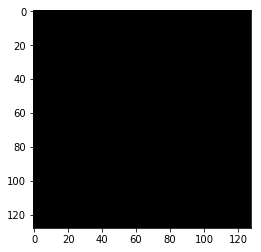

In [29]:
plt.imshow(experiment_pic*255,"gray")

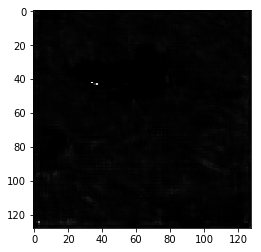

In [30]:
plt.imshow(prediction[0]*255,"gray")

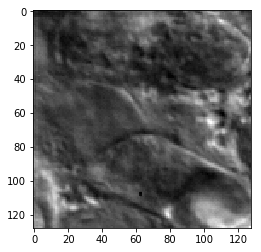

In [31]:
plt.imshow(x_test[0].reshape(128,128)*255,"gray")

In [32]:
out = combine_predictions(prediction,image_shapes)

In [33]:
print(out.shape,len(test_set))

(114,) 114


In [34]:
output = []
threshold = 0.00001
o = np.array(out)
for image in o:
    new_image = select_cilia(image,threshold)
    output.append(new_image)
    

In [35]:
output[1]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

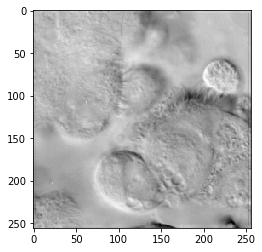

In [36]:
plt.imshow(test_set[2]*255,"gray")

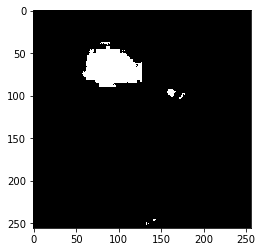

In [37]:
plt.imshow(output[2]*255,"gray")

In [ ]:
hash_List = get_hash()

In [ ]:
for i in range(len(output)):
    ha = hash_List[i]
    image= output[i]
    cv2.imwrite("data/" + str(ha) + ".png", image)